In [1]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")


--- VRAM USAGE REPORT ---
Memory Allocated: 0.00 MB
Memory Reserved:  0.00 MB
-------------------------



In [3]:
`import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([

    A.Resize(height=224, width=224),
    A.RandomCrop(height=180, width=180, p=1.0),
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.4),

    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.4),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.4),

    A.OneOf([
        A.GaussNoise(std_range=(0.1, 0.2), per_channel=True, p=0.4),
        A.RandomRain(slant_range=(-15, 15), drop_length=15, drop_width=1, rain_type="default", blur_value=7, p=0.4),
        A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(0.1, 0.25), hole_width_range=(0.1, 0.25), fill=0, p=0.4)
    ], p=0.5),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

basic_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Rotate(limit=(-45,45), p=0.7),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [4]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

In [9]:
import torchvision.models as models
import torch.nn as nn

class PestClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: new layer for 6 rice pests.
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(num_filters, num_classes),
        )

    # Forward propagation
    def forward(self, x):

       features = self.base_model.features(x)

       features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       features = self.base_model.classifier(features)

       return features

    def unfreeze_feature_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        # Corrected print statement
        print(f"\nUnfreezing feature layer at index: -{layer}")

        for param in self.base_model.features[-layer].parameters():
            param.requires_grad = True


In [8]:
class PestClassifierEfficientNetV2M(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierEfficientNetV2M, self).__init__()

        self.base_model = models.efficientnet_v2_m(weights='EfficientNet_V2_M_Weights.IMAGENET1K_V1')

        for params in self.base_model.parameters():
            params.requires_grad = False

        features = self.base_model.classifier[1].in_features

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        features = self.base_model.features(x)

        features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

        features = self.base_model.classifier(features)

        return features

    def unfreeze_feature_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        print(f"\nUnfreezing feature layer at index: -{layer}")

        for params in self.base_model.features[-layer].parameters():
            params.requires_grad = True


In [11]:
import torch
from tqdm import tqdm

def train_and_test(model, optimizer, criterion, train_dataloader, test_dataloader, num_epoch, device, best_accuracy=0.0):

    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(num_epoch):

        # --- TRAINING PHASE ---
        model.train()
        running_train_loss = 0.0

        for data, labels in tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}"):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        # --- TESTING PHASE ---
        model.eval()
        running_test_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():

            for data, labels in tqdm(test_dataloader, desc=f"Test epoch: {epoch+1}"):
                data, labels = data.to(device), labels.to(device)

                output = model(data)
                loss = criterion(output, labels)
                running_test_loss += loss.item()
                _, predicted = torch.max(output, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

        testing_loss = running_test_loss / len(test_dataloader)
        test_losses.append(testing_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        epoch_summary = f'Epoch {epoch+1}/{num_epoch} | Train Loss: {training_loss:.4f} | Test Loss: {testing_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.3f}/{reserved_gb:.3f} GB'

        tqdm.write(epoch_summary)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'models/EfficientNetV2/EfficientNetV2-m_rice_pest_classificationV2.pt')

        # scheduler.step(testing_loss)

    tqdm.write('Phase done!')

    return {'train_loss': train_losses, 'test_loss': test_losses, 'accuracy': accuracies}, best_accuracy

<h2>  Saving and plott</h2>

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_training_result(*results):

    full_training_loss = []
    full_test_loss = []

    for result in results:
        train_loss = result.get('train_loss', [])
        full_training_loss.extend(train_loss)
        full_test_loss.extend(result.get('test_loss', []))

    total_epochs = len(full_training_loss)

    if total_epochs == 0:
        print("No data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': full_training_loss,
        'Testing Loss': full_test_loss,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Testing Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(*results):

    full_accuracy = []

    for res in results:
        accuracy = res.get('accuracy', [])
        full_accuracy.extend(accuracy)

    total_epochs = len(full_accuracy)

    if total_epochs == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, full_accuracy, label='Accuracy', marker='o', color='g')

    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def accuracy_per_session(session_accuracies):

    total_sessions = len(session_accuracies)
    if total_sessions == 0: return
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, total_sessions + 1), session_accuracies, label='Best Session Accuracy', marker='o', color='r')
    plt.title('Best Accuracy per Training Session')
    plt.xlabel('Training Session')
    plt.ylabel('Best Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_historical_data(history, filename='training_results/EfficientNetV2/SEfficientNetV2-m_rice_pest_classificationV1.csv'):

    train_loss = history.get('train_loss', [])
    test_loss = history.get('test_loss', [])
    accuracy = history.get('accuracy', [])

    data_dict = pd.DataFrame({
        'train_loss': train_loss,
        'test_loss': test_loss,
        'accuracy': accuracy,
    })

    if os.path.exists(filename):
        print("historical data exists! Appending new data.")

        old_data = pd.read_csv(filename)
        combined_data = pd.concat([old_data, data_dict], ignore_index=True)

    else:
        print("Creating new historical data...")
        combined_data = data_dict

    combined_data['epoch'] = range(1, len(combined_data) + 1)

    combined_data = combined_data[['epoch', 'train_loss', 'test_loss', 'accuracy']]

    combined_data.to_csv(filename, index=False)

    print("Historical data saved successfully!")


In [15]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='datasets/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)
val_set = CustomDataset(root='datasets/val', transform=validation_pipeline)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

classes = train_set.classes

In [16]:
def incremental_training(model, sessions, criterion, train_dataloader, test_dataloader, device):

    full_history = []
    session_best_accuracies = []
    best_overall_accuracy = 0.0

    for i, session in enumerate(sessions):
        print(f"\n--- Starting Training Session {i+1}/{len(sessions)} ---")

        epochs = session['epochs']
        lr = session['lr']
        layer_to_unfreeze = session.get('unfreeze_layer', 0)

        if layer_to_unfreeze > 0:
            model.unfreeze_feature_layer(layer_to_unfreeze)

        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-2)

        session_history, best_overall_accuracy = train_and_test(
            model, optimizer, criterion, train_dataloader, test_dataloader, epochs, device, best_accuracy=best_overall_accuracy
        )

        full_history.append(session_history)

        save_historical_data(session_history)

        if session_history['accuracy']:
            best_in_session = max(session_history['accuracy'])
            session_best_accuracies.append(best_in_session)

    return full_history, session_best_accuracies


--- Starting Training Session 1/3 ---


Test epoch: 1: 100%|██████████| 34/34 [00:12<00:00,  2.78it/s]


Epoch 1/2 | Train Loss: 1.7171 | Test Loss: 1.5712 | Accuracy: 48.03% | GPU Memory (Alloc/Reserved): 0.374/1.877 GB


Test epoch: 2: 100%|██████████| 34/34 [00:10<00:00,  3.36it/s]


Epoch 2/2 | Train Loss: 1.5696 | Test Loss: 1.4330 | Accuracy: 54.50% | GPU Memory (Alloc/Reserved): 0.374/1.877 GB
Phase done!
Creating new historical data...
Historical data saved successfully!

--- Starting Training Session 2/3 ---

Unfreezing feature layer at index: -1


Test epoch: 1: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 1/4 | Train Loss: 1.3472 | Test Loss: 1.0409 | Accuracy: 66.74% | GPU Memory (Alloc/Reserved): 0.382/1.879 GB


Test epoch: 2: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 2/4 | Train Loss: 1.1359 | Test Loss: 0.8551 | Accuracy: 71.29% | GPU Memory (Alloc/Reserved): 0.382/1.879 GB


Test epoch: 3: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 3/4 | Train Loss: 1.0178 | Test Loss: 0.7525 | Accuracy: 73.83% | GPU Memory (Alloc/Reserved): 0.382/1.879 GB


Test epoch: 4: 100%|██████████| 34/34 [00:10<00:00,  3.39it/s]


Epoch 4/4 | Train Loss: 0.9250 | Test Loss: 0.6769 | Accuracy: 77.58% | GPU Memory (Alloc/Reserved): 0.382/1.879 GB
Phase done!
historical data exists! Appending new data.
Historical data saved successfully!

--- Starting Training Session 3/3 ---

Unfreezing feature layer at index: -2


Test epoch: 1: 100%|██████████| 34/34 [00:09<00:00,  3.43it/s]


Epoch 1/6 | Train Loss: 0.6627 | Test Loss: 0.3428 | Accuracy: 88.88% | GPU Memory (Alloc/Reserved): 0.582/3.898 GB


Test epoch: 2: 100%|██████████| 34/34 [00:09<00:00,  3.49it/s]


Epoch 2/6 | Train Loss: 0.4371 | Test Loss: 0.2904 | Accuracy: 90.81% | GPU Memory (Alloc/Reserved): 0.583/3.898 GB


Test epoch: 3: 100%|██████████| 34/34 [00:16<00:00,  2.07it/s]


Epoch 3/6 | Train Loss: 0.3769 | Test Loss: 0.2199 | Accuracy: 92.54% | GPU Memory (Alloc/Reserved): 0.583/3.898 GB


Test epoch: 4: 100%|██████████| 34/34 [00:15<00:00,  2.16it/s]


Epoch 4/6 | Train Loss: 0.3076 | Test Loss: 0.2017 | Accuracy: 93.90% | GPU Memory (Alloc/Reserved): 0.583/3.898 GB


Test epoch: 5: 100%|██████████| 34/34 [00:12<00:00,  2.64it/s]


Epoch 5/6 | Train Loss: 0.2766 | Test Loss: 0.2215 | Accuracy: 93.25% | GPU Memory (Alloc/Reserved): 0.583/3.898 GB


Test epoch: 6: 100%|██████████| 34/34 [00:10<00:00,  3.38it/s]


Epoch 6/6 | Train Loss: 0.2547 | Test Loss: 0.1745 | Accuracy: 94.70% | GPU Memory (Alloc/Reserved): 0.583/3.898 GB
Phase done!
historical data exists! Appending new data.
Historical data saved successfully!


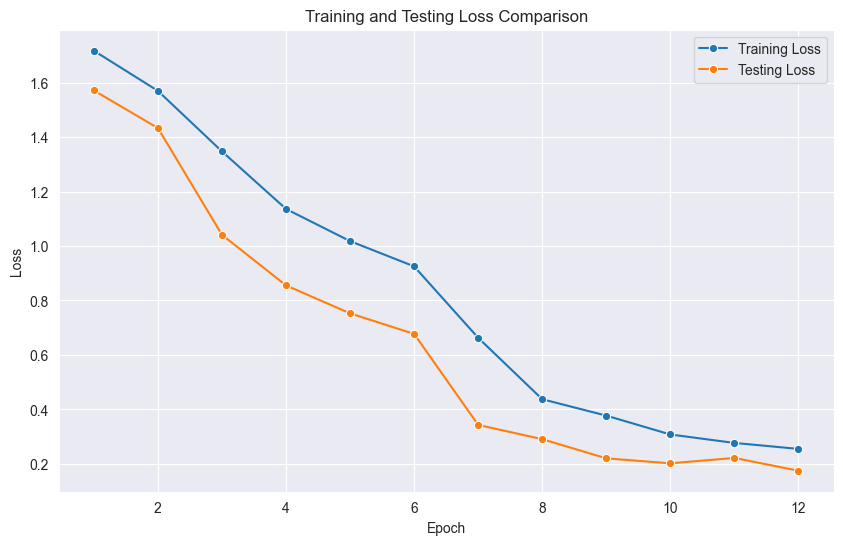

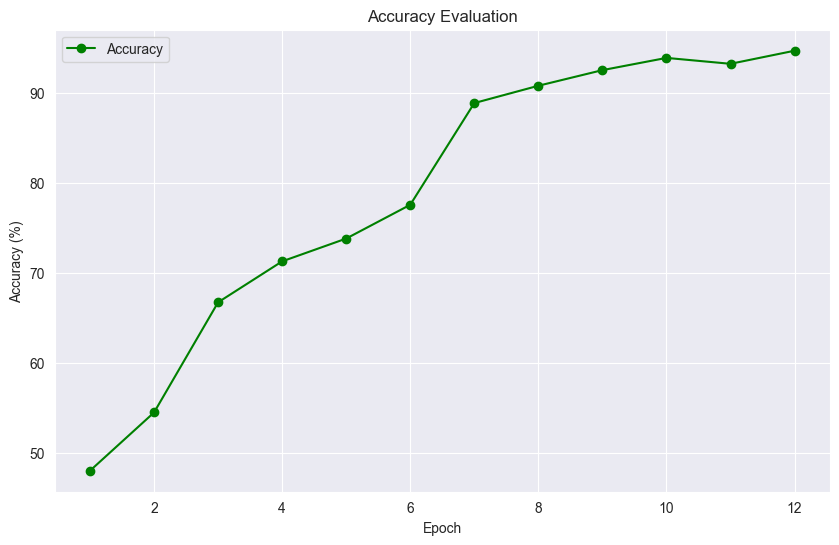

In [22]:
import torch.optim as optim

hardware = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
classes = 6
learning_rate = 1e-3
weight_decay = 1e-2
criterion = nn.CrossEntropyLoss()

model = PestClassifierEfficientNetV2M(num_classes=classes).to(hardware)

training_sessions = [
    {'epochs': 15, 'lr': 1e-4, 'unfreeze_layer': 0},
    {'epochs': 25, 'lr': 1e-4, 'unfreeze_layer': 1},
    {'epochs': 35, 'lr': 1e-4, 'unfreeze_layer': 2}
]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, test_dataloader=test_loader, device=hardware)

plot_training_result(*result)
plot_accuracy(*result)

In [261]:
# mobilenet_v2 = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')
#
# for num in range(len(mobilenet_v2.features) - 1, -1, -1):
#     print(num)

my_array = [1, 2, 3, 4, 5]

# print(my_array[-5])

for num in range(1, my_array.__len__() + 1):
    print(num)

1
2
3


In [15]:
from PIL import Image
import numpy as np
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)

    model.eval()

    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    augmented = transform(image=image_np)

    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        result = model(image_tensor)

        probabilities = F.softmax(result, dim=1)

        confidence, predicted_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_index.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score, probabilities.squeeze().cpu().numpy()


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def eval_metrics(model, testLoader, classes_names, device):

    model.to(device)
    model.eval()

    total_predictions = []
    true_labels = []

    with torch.no_grad():

        for input, labels in tqdm(testLoader):
            input, labels = input.to(device), labels.to(device)

            output = model(input)
            _, predicted = torch.max(output, 1)

            total_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())


    y_true = np.array(true_labels)
    y_pred = np.array(total_predictions)

    print('Classification Report')
    report = classification_report(y_true, y_pred, target_names=classes_names)

    print(report)

    print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%\n")

    print('Confusion Matrix')

    matrix = confusion_matrix(y_true, y_pred)

    cm_df = pd.DataFrame(matrix, index=classes_names, columns=classes_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix (standard)')
    plt.ylabel('Actual pests')
    plt.xlabel('Predicted pests')
    plt.show()

    return y_true, y_pred

def save_evalution_result(total_predictions, true_labels):

    data = pd.DataFrame({
        'True Labels': true_labels,
        'Predicted Labels': total_predictions
    })

    data.to_csv('evalution_result.csv', index=False)


In [31]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load('models/MobileNetV2/v2/Basic/SMobileNetV2_rice_pest_classificationV13.pt', map_location=hardware))
image_path = 'datasets/val/rice-black-bug/blackbug5_jpg.rf.424e09d72d12102f5c45f11cebd47d70.jpg'
unrelated = 'unrelated_data/images.jpg'

pest, confidence_score, over_all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Overall score: {over_all_scores}")
#
# true, pred = eval_metrics(model_inference, val_loader, classes_names, hardware)

The predicted pest is: rice-black-bug
Confidence: 94.00%
Overall score: [5.5456121e-02 3.5791690e-03 9.4000769e-01 2.6055515e-05 9.0353707e-05
 8.4059639e-04]
